### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 6
### Due: Saturday, Mar 14th at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [3]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\h'
C:\Users\tonyt\AppData\Local\Temp\ipykernel_28212\731397073.py:6: SyntaxWarning: invalid escape sequence '\h'
  data = np.load("hw_data\hw6_data_1.npy")


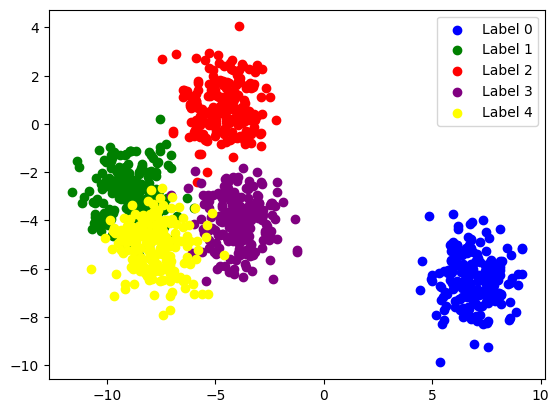

In [ ]:
#1

import numpy as np
import matplotlib.pyplot as plt

data = np.load("hw_data\hw6_data_1.npy") #Importing the dataset

#After doing this next part, I am sure there is an easier or more efficient way.

#Splitting the dataset into individual arrays based on their label by making masks.
a = data[:,2]==0
b = data[:,2]==1
c = data[:,2]==2
d = data[:,2]==3
e = data[:,2]==4

data_a = data[a]
data_b = data[b]
data_c = data[c]
data_d = data[d]
data_e = data[e]

#Plotting these datasets. There is probably a way I could have done this by keeping them in an array
#which would have kept the line count down in the code.
_ = plt.scatter(data_a[:,0],data_a[:,1], c = 'blue', label = "Label 0")
_ = plt.scatter(data_b[:,0],data_b[:,1], c = 'green', label = "Label 1")
_ = plt.scatter(data_c[:,0],data_c[:,1], c = 'red', label = "Label 2")
_ = plt.scatter(data_d[:,0],data_d[:,1], c = 'purple', label = "Label 3")
_ = plt.scatter(data_e[:,0],data_e[:,1], c = 'yellow', label = "Label 4")
_ = plt.legend()

The optimal bandwidth  is: 0.4413793103448276


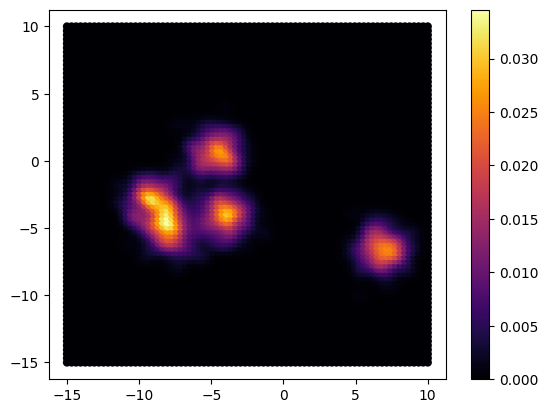

In [21]:
#2
import sklearn as sk

x = np.concatenate([data[:,0],data[:,1]])

bwrange = np.linspace(0.1, 1, 30)
K = 5 #Defining how many folds to cross validate
grid = sk.model_selection.GridSearchCV(sk.neighbors.KernelDensity(), {'bandwidth': bwrange}, cv=5) #Calculating each of the 30 bandwidths using the K-folds
grid.fit(x[:, None])
h_opt = grid.best_params_['bandwidth'] #Calculating optimal bandwidth
print("The optimal bandwidth  is:", h_opt)

X = np.vstack((data[:,0], data[:,1])).T

kde = sk.neighbors.KernelDensity(kernel = 'gaussian', bandwidth = h_opt) #Forming distributions
kde.fit(X) #Fitting the model to the data

u = v = np.linspace(-15,10,80)
xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(xgrid))

_ = plt.scatter(xgrid[:,0], xgrid[:,1], c = dens, cmap = 'inferno', edgecolor = 'None')
_ = plt.colorbar()

While it is hard to tell, I personally believe k = 70 to be the best match, as everything before is too sharp and everything after too blurry.


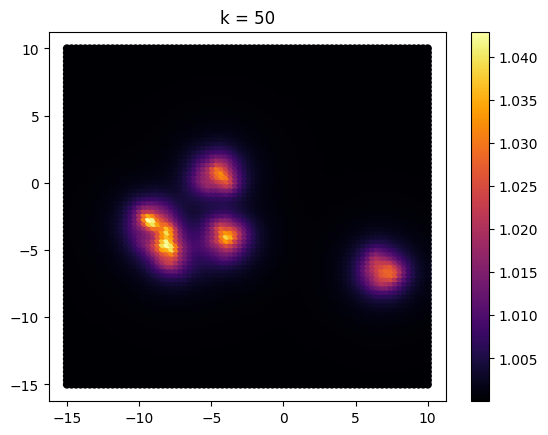

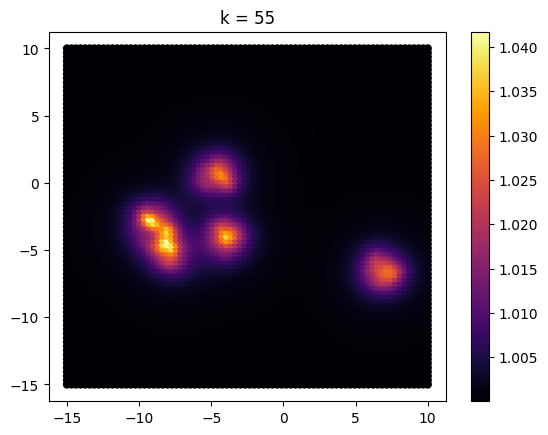

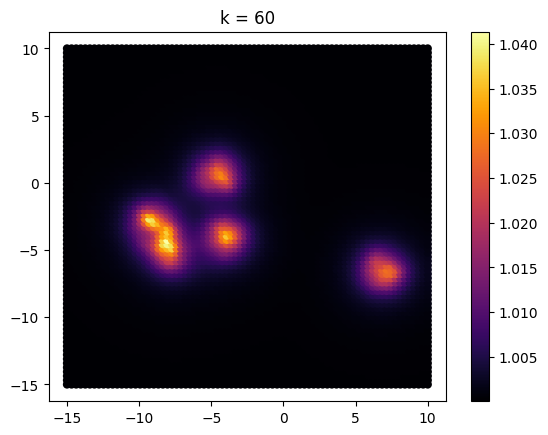

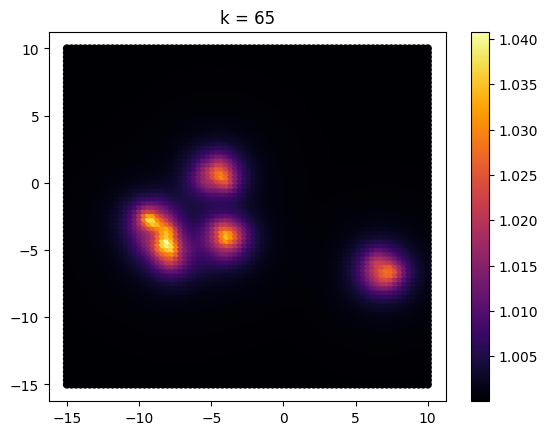

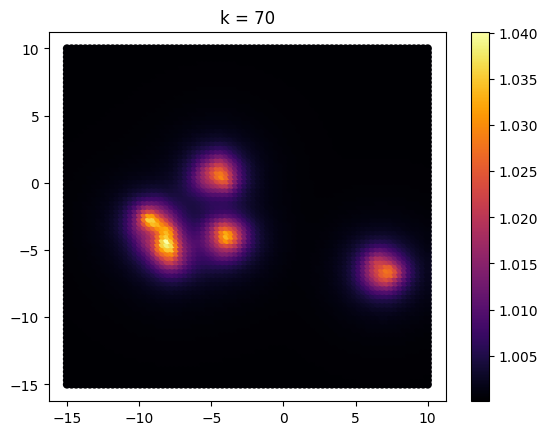

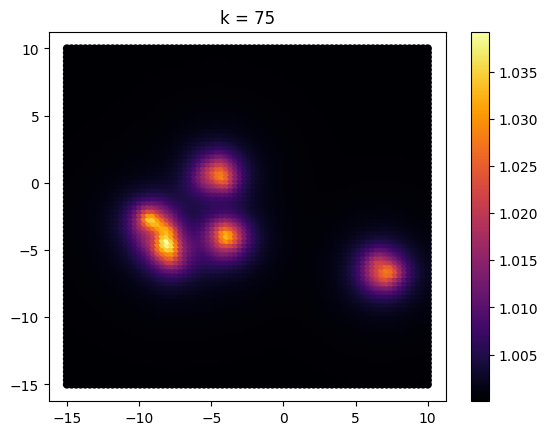

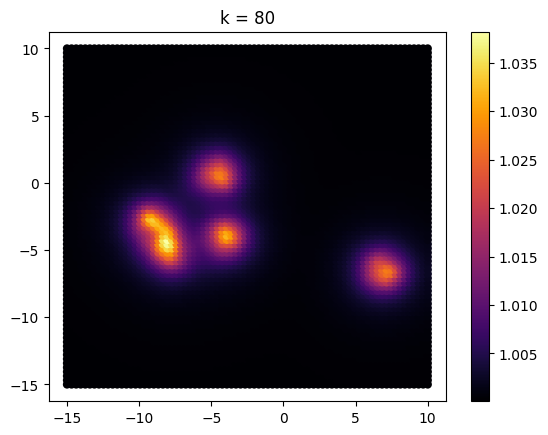

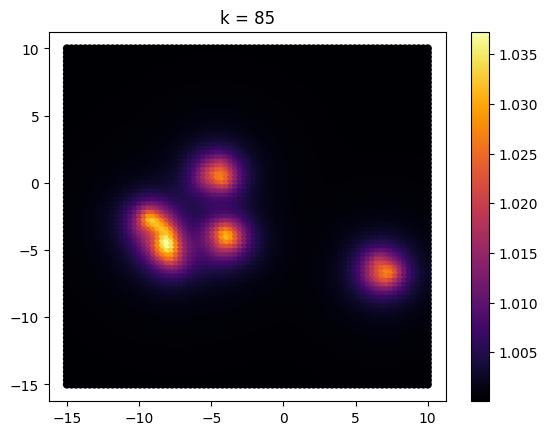

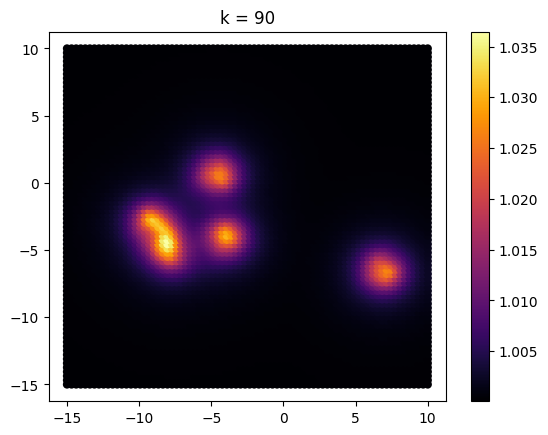

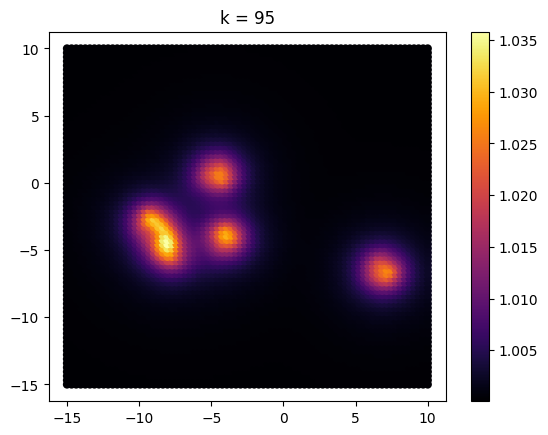

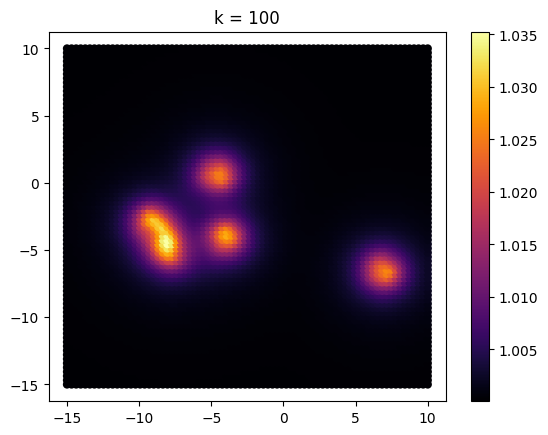

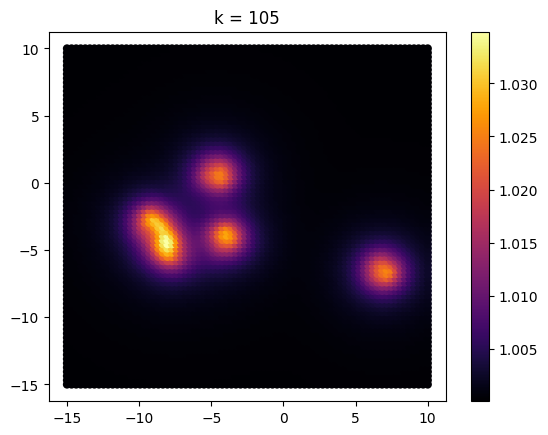

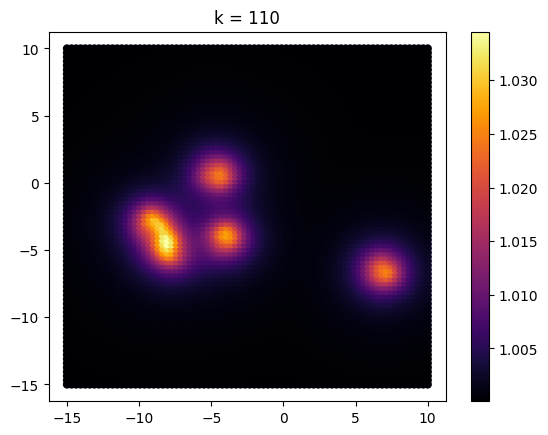

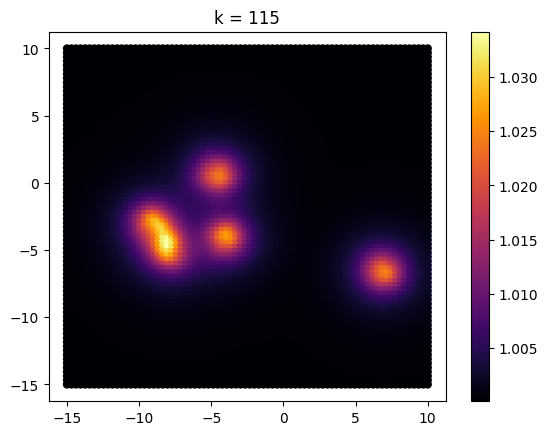

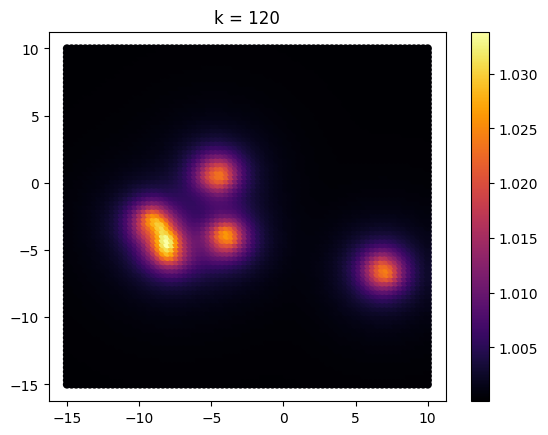

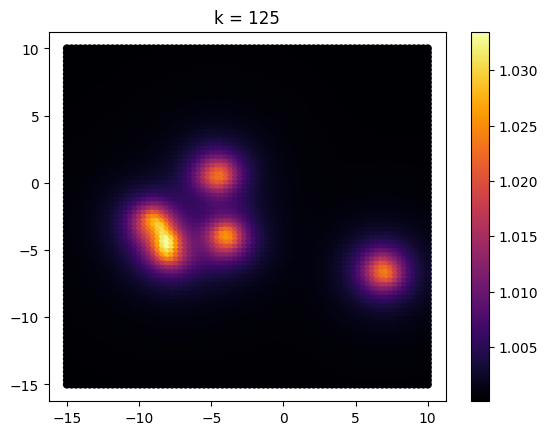

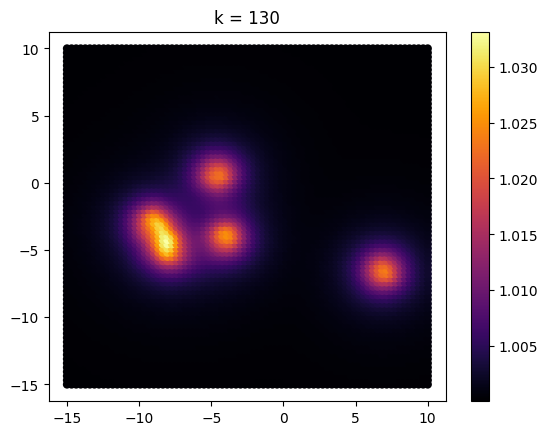

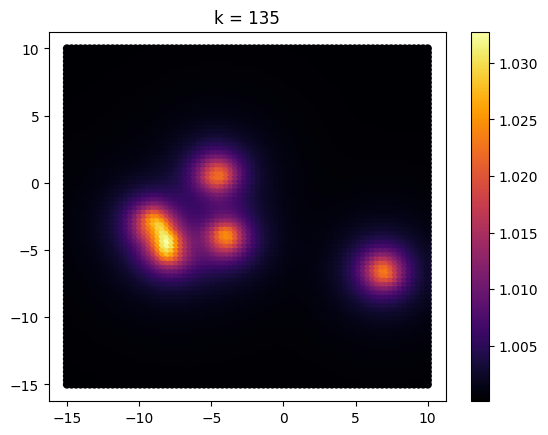

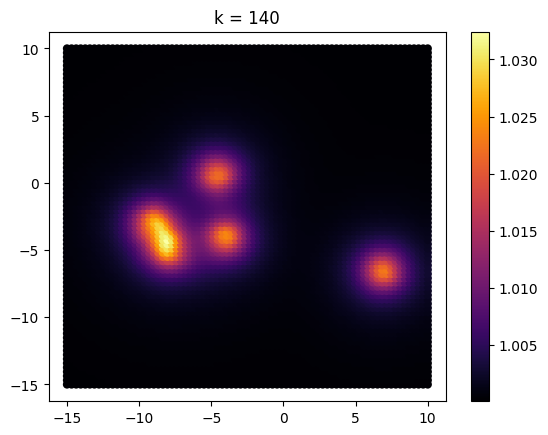

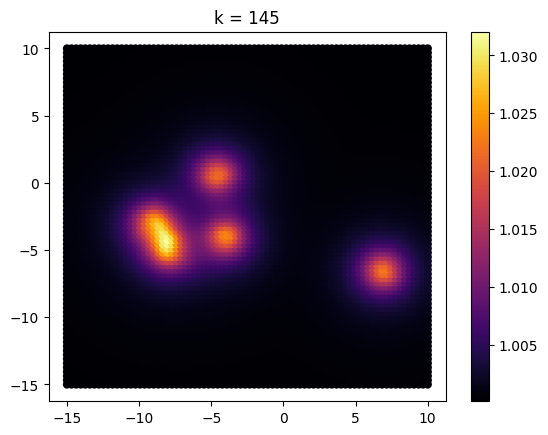

In [ ]:
#3
from astroML.density_estimation import KNeighborsDensity

N = 1000
k = np.arange(50,150,5) #To make sure what k would have to be, I made plots every 5 k to compare.
t = np.linspace(-10,30,1000)

for i in k: #initiating 20 plot loop
    numb = KNeighborsDensity('bayesian', n_neighbors = i)
    numb.fit(X)

    u = v = np.linspace(-15, 10, 80)
    xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
    dens = np.exp(numb.eval(xgrid)/N)
    plt.figure(i)
    _ = plt.scatter(xgrid[:,0], xgrid[:,1], c = dens, cmap = 'inferno', edgecolor = 'none')
    plt.colorbar()
    plt.title("k = " + str(i))

print('While it is hard to tell, I personally believe k = 70 to be the best match, as everything before is too sharp and everything after too blurry.')

<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
C:\Users\tonyt\AppData\Local\Temp\ipykernel_28212\3902729681.py:34: SyntaxWarning: invalid escape sequence '\s'
  draw_ellipse(m, c, scales = [2], ax = None, color = "grey", label = '2$\sigma$')


The BIC hits a minimum at 4 components, therefore that is the optimal.


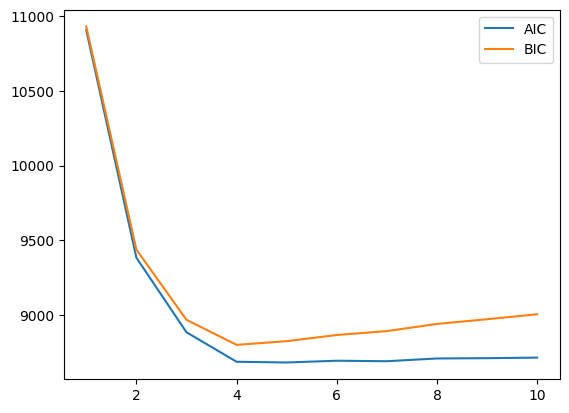

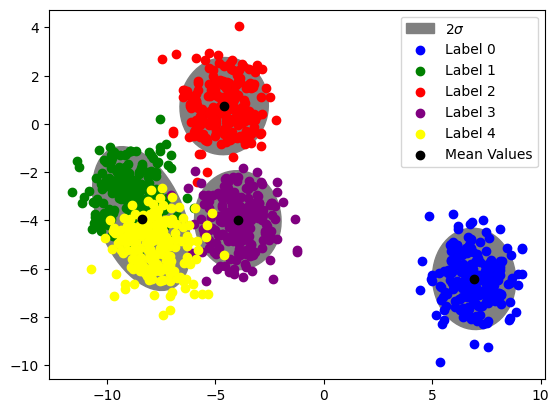

In [26]:
#4
import sklearn as sk

X = np.vstack((data[:,0], data[:,1])).T

N = np.arange(1,11) #Establishing our 10 compoments
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = sk.mixture.GaussianMixture(N[i]).fit(X)

AIC = [m.aic(X) for m in models] #Establish our AIC Model
BIC = [m.bic(X) for m in models] #Establish our BIC Model

plt.figure(1)
_ = plt.plot(N, AIC, label = 'AIC')
_ = plt.plot(N, BIC, label = 'BIC')
_ = plt.legend()

print("The BIC hits a minimum at 4 components, therefore that is the optimal.")

plt.figure(2)

means = sk.mixture.GaussianMixture(n_components= 4, covariance_type= 'full').fit(X)

n  = np.linspace(-15, 10, 1000)
mu = means.means_
C  = means.covariances_
#Drawing elipses
for i in range(len(mu)):
    m = mu[i]
    c = C[i]
    if i == 0:
        draw_ellipse(m, c, scales = [2], ax = None, color = "grey", label = '2$\sigma$')
    else:
        draw_ellipse(m, c, scales = [2], ax = None, color = 'grey')

#Same inefficient method as part 1 to plot all of them.
_ = plt.scatter(data_a[:,0],data_a[:,1], c = 'blue', label = "Label 0")
_ = plt.scatter(data_b[:,0],data_b[:,1], c = 'green', label = "Label 1")
_ = plt.scatter(data_c[:,0],data_c[:,1], c = 'red', label = "Label 2")
_ = plt.scatter(data_d[:,0],data_d[:,1], c = 'purple', label = "Label 3")
_ = plt.scatter(data_e[:,0],data_e[:,1], c = 'yellow', label = "Label 4")

_ = plt.scatter(mu[:,0], mu[:,1], c = 'black', label = 'Mean Values')
_ = plt.legend()

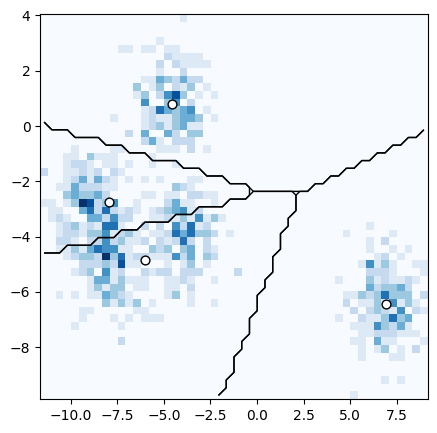

In [ ]:
#5

#This code was taken from Lecture 14, with values modified to work work with preexisting variables.

scaler = sk.preprocessing.StandardScaler()
clf = sk.cluster.KMeans(n_clusters= 4)
clf.fit(scaler.fit_transform(X))

cluster_centers = scaler.inverse_transform(clf.cluster_centers_)

labels = clf.predict(X)



fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(4):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

plt.show()